## PART1: Dataset Exploration

#### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as py

%matplotlib inline

In [2]:
df = pd.read_csv("lending-club-data.csv")

/usr/lib/python3/dist-packages/pandas/io/parsers.py:1139: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


#### What is the number of observations? What is the number of attributes in the dataset?

In [3]:
df.shape

(122607, 68)

In [4]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1,1,1,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1,1,1,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1,1,1,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1,1,1,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1,1,1,0,5.21533,20141201T000000,1,1,1


In [5]:
# change 0 to 1 and 1 to -1
# 1 means good loan
# -1 means bad loan
bad_loans_map = {1: -1, 0: 1}

In [6]:
df["bad_loans"] = df["bad_loans"].map(bad_loans_map)

#### True/False ratio

In [7]:
num_good_loans = len(df.loc[df["bad_loans"] == 1])
num_bad_loans = len(df.loc[df["bad_loans"] == -1])
print("Good loans: {0:.2f}%".format(num_good_loans/len(df) * 100))
print("Bad loans:  {0:.2f}%".format(num_bad_loans/len(df) * 100))

Good loans: 81.12%
Bad loans:  18.88%


#### Does this distribution (split) make the problem of identifying risky loans challenging? Explain your answer.

!!!The lending club data is imbalanced, and the ratio is around 81:19. This could cause ploblems. One of problems, is misleading the answer, beause one classificaiton has a way more data then other classification. This could lead our model to predict the only one type of classification which gives more model accuracy.

## PART2: Feature Selection

In [8]:
feature_col_names = ["grade","sub_grade","short_emp","emp_length_num","home_ownership","dti","purpose","term","last_delinq_none","last_major_derog_none","revol_util","total_rec_late_fee"]
predicted_class_names = ["bad_loans"]
X_df = df[feature_col_names]

## PART3: Building a Decision Trees Classifier 

#### Check # of unique categores for each categorical feature

In [9]:
feature_col_categorical = ["grade","sub_grade","home_ownership","purpose","term"]
for col_name in feature_col_categorical:
    cat_unique = len(df[col_name].unique())
    print("Feature '{0}' has {1} unique categories".format(col_name,cat_unique))

Feature 'grade' has 7 unique categories
Feature 'sub_grade' has 35 unique categories
Feature 'home_ownership' has 4 unique categories
Feature 'purpose' has 12 unique categories
Feature 'term' has 2 unique categories


#### Dummy variables

In [10]:
def dummy_df(df, dummy_list):
    for dummy in dummy_list:
        dummies = pd.get_dummies(X_df[dummy], prefix=dummy, dummy_na=False)
        df = df.drop(dummy,1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [11]:
# If I were using pandas 0.19.2, I could have used different approach
# pd.get_dummies(df, columns=['category1','category2'], drop_first=True)
# drop_frist: k-1 dummies
X_df = dummy_df(X_df, feature_col_categorical)


X = X_df.values
y = df[predicted_class_names].values

#### Splitting the data

In [12]:
from sklearn.model_selection import train_test_split

split_test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = split_test_size, random_state=42)

#### We check to ensure we have the desired 70% train, 20% test split of the data

In [13]:
print("{0:.2f}% in training data".format(len(X_train)/len(X) * 100))
print("{0:.2f}% in test data".format(len(X_test)/len(X) * 100))

80.00% in training data
20.00% in test data


#### Create a D3 model

In [14]:
from sklearn import tree

In [15]:
d3_model = tree.DecisionTreeClassifier(class_weight='balanced')
d3_model.fit(X_train, y_train)

d3_model_small = tree.DecisionTreeClassifier(max_depth=2, class_weight='balanced') 
d3_model_small.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Part 4: (Optional) Visualizing the learned model

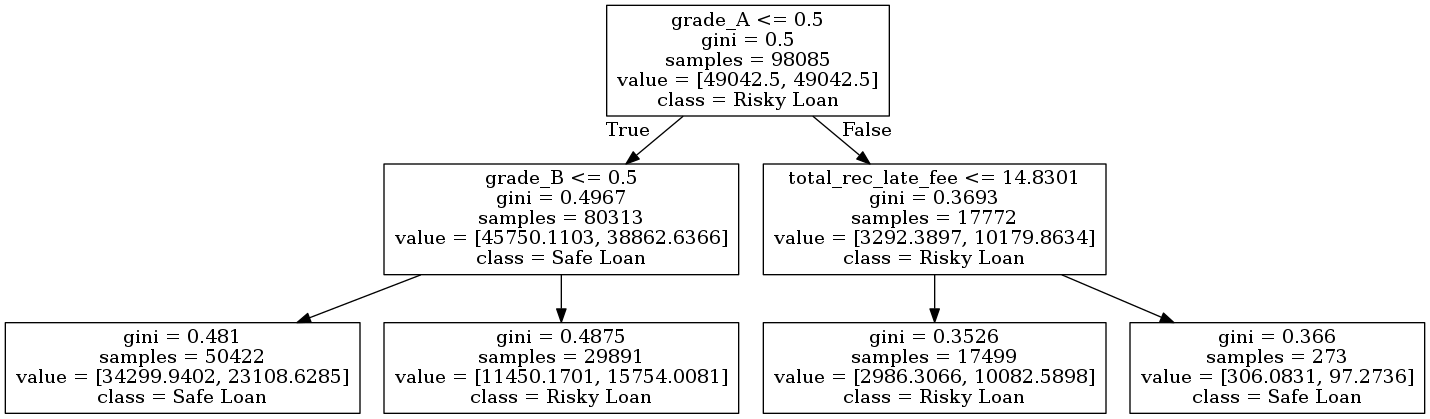

In [16]:
from IPython.display import Image 
import pydotplus

dot_data = tree.export_graphviz(d3_model_small, out_file=None, feature_names=list(X_df.columns), class_names=["Safe Loan","Risky Loan"])
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

#### Which feature is the root of the decision_tree_model?

In [17]:
# dot_data = tree.export_graphviz(d3_model, out_file=None, feature_names=list(X_df.columns), class_names=["Safe Loan","Risky Loan"])
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())

## Part 5: Making predictions and exploring predictions

In [18]:
# 0 1
# 1 1
# 2 -1
# 8 -1
X_samples = [X_test[0],X_test[1],X_test[2],X_test[8]]
y_samples = [y_test[0],y_test[1],y_test[2],y_test[8]]
d3_predict_test = d3_model.predict(X_samples)

#### What percentage of the predictions on these 4 samples did decision_tree_modelget correct?

In [19]:
from sklearn import metrics


print("{0:.2f}% get correct".format(metrics.accuracy_score(y_samples, d3_predict_test)*100))

75.00% get correct


#### What is the probability (according to decision_tree_model) of a loan being classified as safe? (If you are using scikit-learn, you can use the .predict_proba() method)

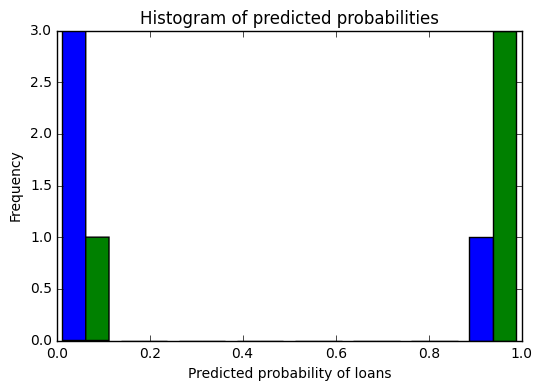

In [20]:
d3_predict_prob = d3_model.predict_proba(X_samples)
plt.hist(d3_predict_prob, bins=8)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of loans') 
plt.ylabel('Frequency')

#### Which loan has the highest probability of being classified as a safe loan?

A: The first loan of 4 samples has the highest probability of being classified as a safe loan

#### Can you verify that for all the predictions with probability >= 0.5, the model predicted the label +1?

In [21]:
print(d3_predict_prob)

[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]]


Based on above result, the model predicted the label +1 >= 0.5 b/c first 2 samples are safe loan out of given 4 samples.

#### Using the small_model what is the probability of these four loans being classified as safe?

In [22]:
d3_model_small.predict_proba(X_samples)

array([[ 0.59747074,  0.40252926],
       [ 0.59747074,  0.40252926],
       [ 0.59747074,  0.40252926],
       [ 0.59747074,  0.40252926]])

Around 40% these four loans being classified as safe

#### How do these predictions compare to the predictions made by the decision_tree_model?

The model_small has a low probaility of predicting a safe loan compare to decision_tree_model b/c of the tree depth

## Part 6: Evaluating accuracy of the decision tree model

#### What is the accuracy of decision_tree_model on the validation set, rounded to the nearest .01?

In [23]:
d3_predict_train = d3_model.predict(X_train)
d3_small_predect_train = d3_model_small.predict(X_train)

print("Accuracy decisition_tree_model on training data: {0:.2f}%".format(metrics.accuracy_score(d3_predict_train, y_train) * 100))
print("Accuracy model_small on training data: {0:.2f}%".format(metrics.accuracy_score(d3_small_predect_train, y_train) * 100))

d3_predict_test = d3_model.predict(X_test)

print("\nAccuracy decisition_tree_model on validation data: {0:.2f}%".format(metrics.accuracy_score(d3_predict_test, y_test) * 100))

Accuracy decisition_tree_model on training data: 100.00%
Accuracy model_small on training data: 56.04%

Accuracy decisition_tree_model on validation data: 71.21%


## Part 7: A complex decision tree model

In [24]:
d3_model_big = tree.DecisionTreeClassifier(max_depth=10, class_weight='balanced') 
d3_model_big.fit(X_train,y_train)
d3_predict_big_train = d3_model_big.predict(X_train)
d3_predict_big_test = d3_model_big.predict(X_test)



#### How does the performance of the big_model compare to the performance of the decision_tree_model on the training set?

In [25]:
print("Accuracy model_big on training data: {0:.2f}%".format(metrics.accuracy_score(d3_predict_big_train, y_train) * 100))
print("Accuracy decisition_tree_model on training data: {0:.2f}%".format(metrics.accuracy_score(d3_predict_train, y_train) * 100))

Accuracy model_big on training data: 66.41%
Accuracy decisition_tree_model on training data: 100.00%


#### How does the performance of the big_model compare to the performance of the decision_tree_model on the validation set? 

In [26]:
print("Accuracy model_big on validation data: {0:.2f}%".format(metrics.accuracy_score(d3_predict_big_test, y_test) * 100))
print("Accuracy decisition_tree_model on validation data: {0:.2f}%".format(metrics.accuracy_score(d3_predict_test, y_test) * 100))

Accuracy model_big on validation data: 64.95%
Accuracy decisition_tree_model on validation data: 71.21%


#### Which model would you recommend as a final predictor for whether or not a loan provided by LendingClub is likely to default? Explain your recommendation.

I would recommend a decisition_tree_model as a final predictor b/c it predicts better based on accuracy score. However, I still need to use other matrixies to make a final decistion. Accuracy score is not enough to make a decistion for selecting a final candidate model due to a ratio of bad_loans 81:19.

## Part 8: Quantifying the cost of mistakes

In [27]:
print("Confustion matrix:\n {0}".format(metrics.confusion_matrix(y_test, d3_predict_test, labels=[1,-1])))

Confustion matrix:
 [[16238  3560]
 [ 3499  1225]]


* TP: 16293
* FP: 3505
* FN: 3487
* TN: 1237

#### If we assume that each false negative costs \$10,000, while a false positive costs $20,000. What is the total cost of mistakes made by the decision_tree_model on the validation_data?

In [28]:
print("The total cost of mistakes made by the decision_tree_model on the validation_data: {0}$".format((3505*20000)+(3487*10000)))

The total cost of mistakes made by the decision_tree_model on the validation_data: 104970000$
